In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [2]:
DATA_DIR = "../datasets_full"
LONDON_BOROUGH_SHAPES = "./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

In [3]:
ug_activity = pd.read_csv(os.path.join(DATA_DIR, 'London', 'london_underground_activity.csv'))

In [4]:
ug_activity.head()

,year,nlc,station,area,weekday_entry,weekday_exit,saturday_entry,saturday_exit,sunday_entry,sunday_exit,annual_entry_and_exit
0,2007,500,Acton Town,Ealing,9205,8899.0,6722,6320,4427,4304,5.77
1,2007,502,Aldgate,City of London,9887,10397.0,2191,2587,1484,1772,5.57
2,2007,503,Aldgate East,Tower Hamlets,12820,12271.0,7040,6220,5505,5000,7.66
3,2007,505,Alperton,Brent,4611,4719.0,3354,3450,2433,2503,3.01
4,2007,506,Amersham,Chiltern,4182,3938.0,1709,1585,1004,957,2.34


In [26]:
area_annual_act = ug_activity.pivot_table(index='area', columns='year', values='annual_entry_and_exit', aggfunc=np.sum)

In [27]:
area_annual_act.head()

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
area,,,,,,,,,,,
Barking and Dagenham,22.77,22.29,23.74,24.41,25.76,26.68,28.14,29.98,31.154386,31.15,33.62
Barnet,44.58,47.17,48.18,49.51,51.37,50.31,50.43,56.07,59.198246,61.25,63.56
Brent,79.77,79.75,77.18,74.68,78.07,81.43,84.65,90.88,94.158019,96.47,98.09
Camden,237.24,243.57,245.91,255.75,267.96,275.81,285.25,304.79,315.279853,309.28,308.83
Chiltern,4.08,3.81,3.63,3.67,3.91,4.02,3.84,4.73,4.599944,4.92,5.12


In [28]:
area_annual_act.index

Index(['Barking and Dagenham', 'Barnet', 'Brent', 'Camden', 'Chiltern',
       'City of London', 'City of Westminster', 'Ealing', 'Enfield',
       'Epping Forest', 'Greenwich', 'Hackney', 'Hammersmith and Fulham',
       'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Lambeth', 'Merton', 'Newham', 'Redbridge',
       'Richmond', 'Southwark', 'Three Rivers', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Watford'],
      dtype='object', name='area')

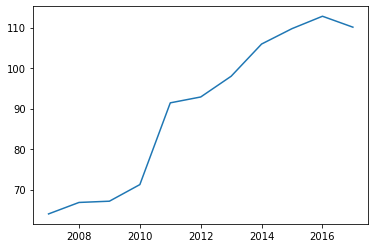

In [29]:
plt.plot(area_annual_act.loc['Newham'])

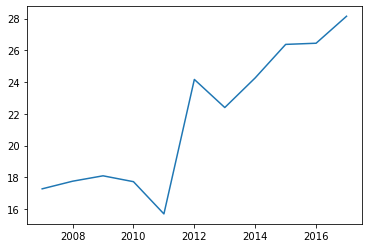

In [51]:
plt.plot(area_annual_act.loc['Greenwich'])

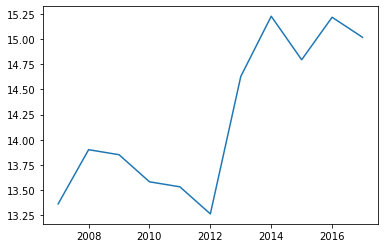

In [45]:
plt.plot(area_annual_act.loc['Enfield'])

In [31]:
map_df = gpd.read_file(LONDON_BOROUGH_SHAPES)

In [32]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


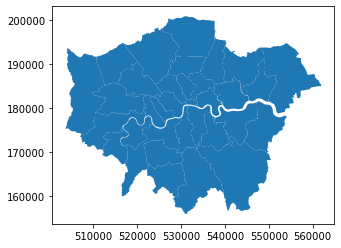

In [33]:
map_df.plot()

In [34]:
merged = map_df.set_index('NAME').join(area_annual_act)

In [35]:
merged[2012]

NAME
Kingston upon Thames         NaN
Croydon                      NaN
Bromley                      NaN
Hounslow                   24.05
Ealing                     61.62
Havering                   10.32
Hillingdon                 40.29
Harrow                     29.96
Brent                      81.43
Barnet                     50.31
Lambeth                   169.14
Southwark                 125.25
Lewisham                     NaN
Greenwich                  24.17
Bexley                       NaN
Enfield                    13.26
Waltham Forest             45.35
Redbridge                  31.81
Sutton                       NaN
Richmond upon Thames         NaN
Merton                     30.72
Wandsworth                 50.70
Hammersmith and Fulham    117.25
Kensington and Chelsea    152.85
Westminster                  NaN
Camden                    275.81
Tower Hamlets             135.36
Islington                 130.86
Hackney                     9.23
Haringey                   54.68
Newha

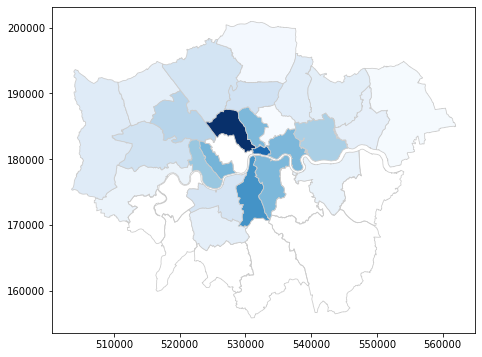

In [55]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=2017, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

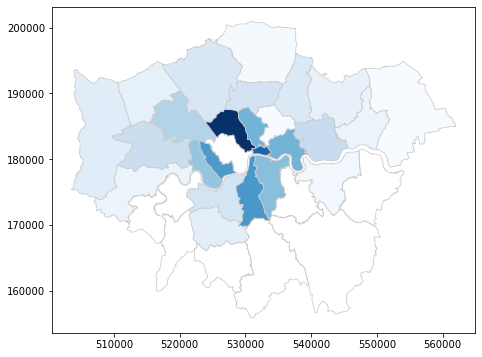

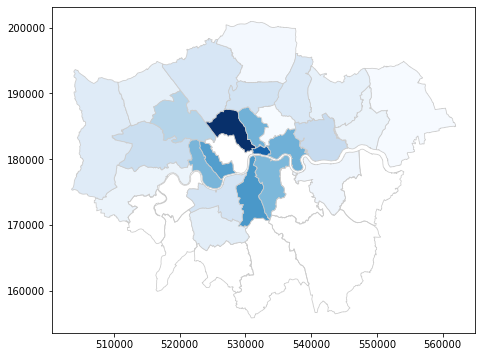

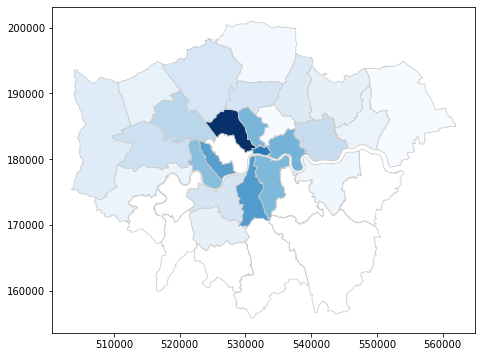

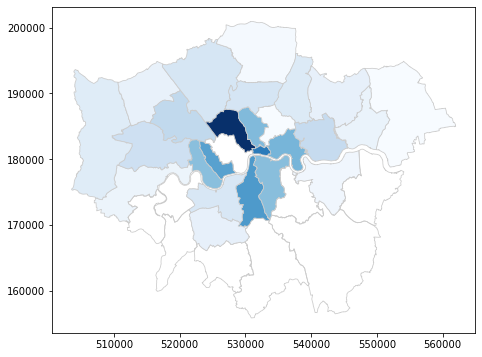

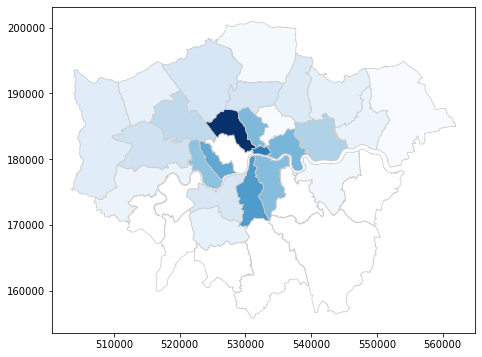

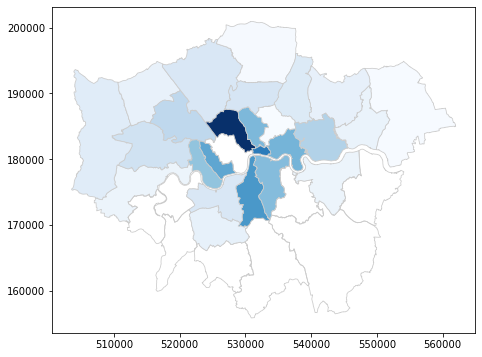

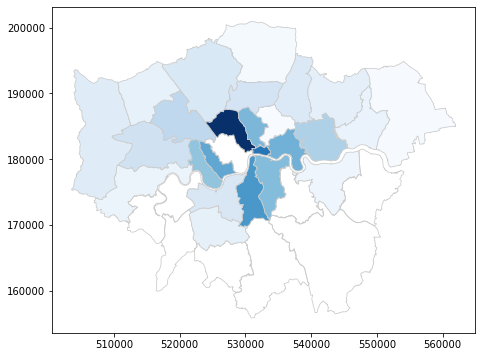

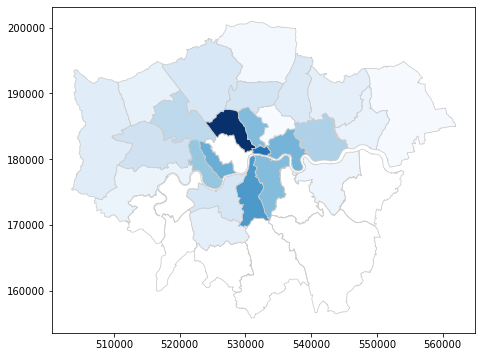

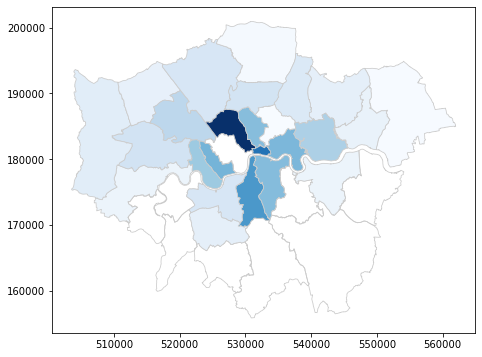

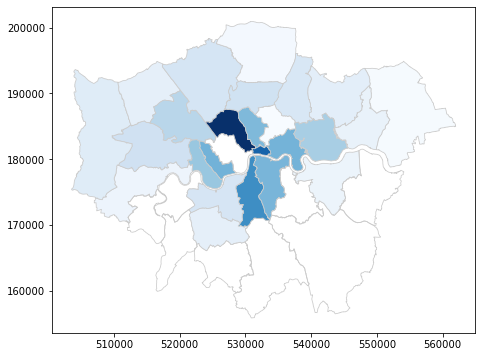

In [44]:
for i in range(2007, 2017):
    fig, ax = plt.subplots(1, figsize=(10, 6))
    merged.plot(column=i, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    plt.show()